In [1]:
import os
import sys
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import re
import subprocess
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

sys.path.append('../src')

In [2]:
data_root = '/media/maxim/SStorage/ComParE2020_Mask/'
features_root = 'features/'
wavs_path = 'wav/'
labels_path = 'lab/labels.csv'

In [3]:
extractor_params = {
    'sample_rate': 16000,
    'window_width': 0.032, # window width in seconds
    'stride': 0.010, # stride in seconds
#     'window_width': 0.022, # window width in seconds
#     'stride': 0.005, # stride in seconds
    'center': False,
}

feature_types = [
    {
        'prefix': 'mel_64',
        'features': {
            'type': 'mel',
            'mel': {
                'n_mels': 64,
            },
        }
    },
    {
        'prefix': 'mfcc_30_0',
        'features': {
            'type': 'mfcc',
            'mfcc': {
                'order': [0],
                'n_mfcc': 30,
            }
        }
    },
    {
        'prefix': 'mfcc_30_1',
        'features': {
            'type': 'mfcc',
            'mfcc': {
                'order': [1],
                'n_mfcc': 30,
            }
        }
    },
    {
        'prefix': 'mfcc_30_2',
        'features': {
            'type': 'mfcc',
            'mfcc': {
                'order': [2],
                'n_mfcc': 30,
            }
        }
    },
    {
        'prefix': 'mfcc_30_0-2',
        'features': {
            'type': 'mfcc',
            'mfcc': {
                'order': [0, 1, 2],
                'n_mfcc': 30,
            }
        }
    }
]

In [4]:
from data.data_sample import DataSample

def read_samples(data_root, labels_path, wavs_path, logging=False):
    datasets = ['train', 'devel', 'test']
    all_labels = pd.read_csv(os.path.join(data_root, labels_path))
    
    all_samples = {}
    for dataset in datasets:
        
        labels_df = all_labels[all_labels['file_name'].str.startswith(dataset)].values
        
        samples = []
        for file_info in labels_df:
            fp = os.path.join(data_root, wavs_path, file_info[0])
            sample = DataSample(wav_path=fp,
                                file_name=file_info[0],
                                file_size=os.path.getsize(fp),
                                label=file_info[1])
    
            samples.append(sample)
        
        all_samples[dataset] = samples
    
    if logging:
        print('Count of samples: {0}'.format(sum([len(v) for k, v in all_samples.items()])))
        print(all_samples['train'][0])
    
    return all_samples

## Save features as CSV

In [ ]:
import csv

from tqdm.notebook import tqdm

from features.librosa_extractor import LibrosaFeatureExtractor

# # hop_length = sr * stride
# # feat_shape ~ seconds * sr / hop_length

reshape = True # Flatten features array
reshape_prefix = '_r' if reshape else ''

for feature_type in feature_types:
    lfe_params = {}
    lfe_params.update(extractor_params)
    lfe_params.update(feature_type['features'])
    lfe = LibrosaFeatureExtractor(params=lfe_params, alignment=None)
    
    all_samples = read_samples(data_root, labels_path, wavs_path)
    
    for ds, samples in all_samples.items():     
        for sample in tqdm(samples, 
                           desc='Extract features from {0} dataset'.format(ds), 
                           total=len(samples), 
                           unit='samples'):
            sample.features = lfe.process(sample)
        
        csv_fn = 'ComParE2020_Mask.{0}{1}.{2}.csv'.format(feature_type['prefix'],
                                                          reshape_prefix, 
                                                          ds)
        csv_filepath = os.path.join(data_root, features_root, csv_fn)
        if os.path.exists(csv_filepath):
            os.remove(csv_filepath)
            
        header = ['file_name']
        if reshape:
            header.extend(
                ['feat_{0}'.format(i) for i in range(0, samples[0].features.size)])
        else:
            header.append('features')
            
        with open(csv_filepath, 'w') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=header, delimiter=',')
            writer.writeheader()
            for sample in tqdm(samples, desc='Writing CSV ({0} dataset)'.format(ds), 
                               total=len(samples), unit='samples'):
                writer.writerow(sample.to_dict(reshape=reshape))

## Show samples

In [5]:
from features.librosa_extractor import LibrosaFeatureExtractor

lfe_params = {}
lfe_params.update(extractor_params)
lfe_params.update(feature_types[0]['features'])
lfe = LibrosaFeatureExtractor(params=lfe_params, alignment=None)
all_samples = read_samples(data_root, labels_path, wavs_path)

In [8]:
def display_samples(samples, lfe, start_from=0, ncols=2, nrows=3):
    sub_samples = samples[start_from:]
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=False, figsize=(15, 10))
    for i, ax in enumerate(axes.flatten()):
        lfe.features_to_img(sub_samples[i], 
                            legend=True, 
                            title='{0}\n{1}'.format(sub_samples[i].file_name, sub_samples[i].label),
                            ax=ax,
                            save=False)
    
    plt.show()

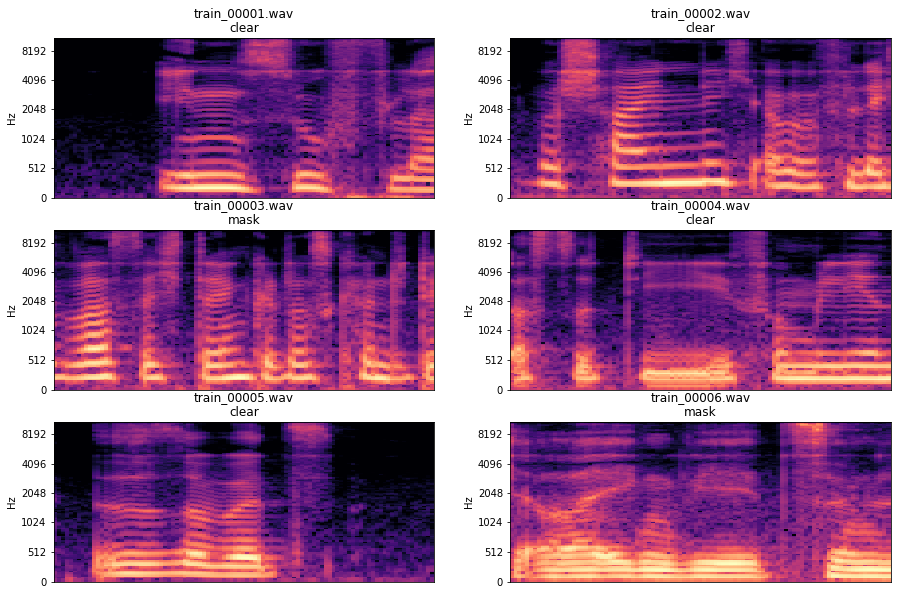

In [9]:
display_samples(all_samples['train'], lfe, start_from=0)

## Save features as image

In [10]:
from tqdm.notebook import tqdm

from features.librosa_extractor import LibrosaFeatureExtractor

for feature_type in feature_types:
    lfe_params = {}
    lfe_params.update(extractor_params)
    lfe_params.update(feature_type['features'])
    lfe = LibrosaFeatureExtractor(params=lfe_params, alignment=None)
    
    all_samples = read_samples(data_root, labels_path, wavs_path)
    
    features_path_root = os.path.join(data_root, features_root, feature_type['prefix'])
    
    if not os.path.exists(features_path_root):
        os.mkdir(features_path_root)
    
    for ds, samples in all_samples.items():
#         if ds == 'train' or ds == 'devel':
#             continue
        
        for sample in tqdm(samples, 
                           desc='Extract features from {0} dataset'.format(ds), 
                           total=len(samples), 
                           unit='samples'):
            if ds == 'test':
                internal_path = os.path.join(features_path_root, ds, 'unknown')
            else:
                internal_path = os.path.join(features_path_root, ds, sample.label)
            
            os.makedirs(internal_path, exist_ok=True)
            
            lfe.features_to_img(sample, 
                                save=True, 
                                fig_size=(4, 4),
                                save_path=os.path.join(internal_path, 
                                                       '{0}.png'.format(sample.file_name.split('.wav')[0])))